<a href="https://colab.research.google.com/github/AnanyaTayalSC/Drafts/blob/main/3layers_64_16_epoch30batchsize32.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from sklearn.cluster import KMeans

# =====================================
# 1. Load CSV and build tensor
# =====================================
#from google.colab import drive
#drive.mount('/content/drive')

csv_file_path = '/content/drive/MyDrive/Colab Notebooks/Thesis/Imp.csv'
df = pd.read_csv(csv_file_path)  # columns: sample_id, time, var1, var2, var3

# Ensure sorting (important!)
df = df.sort_values(by=["sample_id", "time"])

# Pivot to wide format: each (sample_id, time) → row
#X = df.pivot(index=["sample_id", "time"], columns=None, values=["var1","var2","var3"]).reset_index()

# Group by sample_id and collect sequences
X_list = []
for sid, group in df.groupby("sample_id"):
    values = group[["var1","var2","var3"]].values  # shape (T, 3)
    X_list.append(values)

X = np.stack(X_list)  # final shape (N, T, 3)
print("Data shape:", X.shape)  # e.g. (1394, 100, 3)

# Convert to PyTorch tensor
X_tensor = torch.tensor(X, dtype=torch.float32)


# =====================================
# 2. Define LSTM Autoencoder
# =====================================
class LSTMAutoencoder(nn.Module):
    def __init__(self, input_dim=3, hidden_dim=128, latent_dim=64, num_layers=1):
        super(LSTMAutoencoder, self).__init__()

        # Encoder
        self.encoder_lstm = nn.LSTM(input_dim, hidden_dim, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_dim, latent_dim)

        # Decoder
        self.decoder_lstm = nn.LSTM(latent_dim, hidden_dim, num_layers, batch_first=True)
        self.output_layer = nn.Linear(hidden_dim, input_dim)

    def forward(self, x):
        # Encoder
        _, (h, _) = self.encoder_lstm(x)  # h: (num_layers, batch, hidden_dim)
        h = h[-1]                         # (batch, hidden_dim)
        z = self.fc(h)                    # (batch, latent_dim)

        # Decoder (repeat latent vector across all timesteps)
        z_repeated = z.unsqueeze(1).repeat(1, x.size(1), 1)  # (batch, T, latent_dim)
        decoded, _ = self.decoder_lstm(z_repeated)
        out = self.output_layer(decoded)   # (batch, T, 3)

        return out, z


# =====================================
# 3. Train Autoencoder
# =====================================
model = LSTMAutoencoder(input_dim=3, hidden_dim=128, latent_dim=64)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

# Put into batches (for large datasets)
batch_size = 32
num_epochs = 50

dataset = torch.utils.data.TensorDataset(X_tensor)
dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True)

for epoch in range(num_epochs):
    total_loss = 0
    for batch in dataloader:
        x_batch = batch[0]
        optimizer.zero_grad()
        reconstructed, _ = model(x_batch)
        loss = criterion(reconstructed, x_batch)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {total_loss/len(dataloader):.4f}")


# =====================================
# 4. Extract embeddings
# =====================================
with torch.no_grad():
    _, embeddings = model(X_tensor)  # (N, latent_dim)
    embeddings = embeddings.numpy()

print("Embeddings shape:", embeddings.shape)  # (1394, latent_dim)


# =====================================
# 5. Clustering
# =====================================
kmeans = KMeans(n_clusters=5, random_state=42)
labels = kmeans.fit_predict(embeddings)

print("Cluster assignments:", labels[:20])  # first 20 samples


Data shape: (1395, 501, 3)
Epoch 1/50, Loss: 174.4663
Epoch 2/50, Loss: 172.9091
Epoch 3/50, Loss: 172.3471
Epoch 4/50, Loss: 172.6871
Epoch 5/50, Loss: 171.6764
Epoch 6/50, Loss: 170.2187
Epoch 7/50, Loss: 167.5857
Epoch 8/50, Loss: 168.0227
Epoch 9/50, Loss: 167.7789
Epoch 10/50, Loss: 167.6101
Epoch 11/50, Loss: 167.4421
Epoch 12/50, Loss: 167.2229
Epoch 13/50, Loss: 167.3719
Epoch 14/50, Loss: 166.9855
Epoch 15/50, Loss: 167.6029
Epoch 16/50, Loss: 167.8743
Epoch 17/50, Loss: 167.1289
Epoch 18/50, Loss: 166.9393
Epoch 19/50, Loss: 166.8419
Epoch 20/50, Loss: 167.0948
Epoch 21/50, Loss: 166.8197
Epoch 22/50, Loss: 167.0704
Epoch 23/50, Loss: 167.0471
Epoch 24/50, Loss: 166.9582
Epoch 25/50, Loss: 165.3824
Epoch 26/50, Loss: 164.9467
Epoch 27/50, Loss: 163.9933
Epoch 28/50, Loss: 164.3021
Epoch 29/50, Loss: 164.6963
Epoch 30/50, Loss: 165.3320
Epoch 31/50, Loss: 164.3042
Epoch 32/50, Loss: 163.4416
Epoch 33/50, Loss: 163.6325
Epoch 34/50, Loss: 164.1556
Epoch 35/50, Loss: 163.0818
Ep

In [ ]:
np.set_printoptions(threshold=np.inf)  # disable truncation
print(labels)
print("Embeddings shape:", embeddings.shape)   # should be (1329, latent_dim)
print("First few embeddings:\n", embeddings[:5])
unique, counts = np.unique(labels, return_counts=True)
print(dict(zip(unique, counts)))

[2 2 2 2 2 2 2 2 2 2 2 2 2 4 4 2 2 2 2 2 1 4 4 2 1 2 1 4 4 2 1 4 4 1 0 1 2
 2 2 2 2 1 4 4 2 2 2 1 4 4 2 1 4 4 1 4 4 2 2 2 1 4 4 2 1 4 4 2 4 4 2 2 1 4
 4 2 2 4 2 4 4 2 1 4 2 4 4 2 4 4 2 4 2 2 2 2 2 2 2 2 2 2 2 2 2 2 1 4 4 4 4
 4 4 2 2 2 2 1 1 1 4 4 4 4 4 4 2 2 1 1 1 4 0 4 4 0 1 2 1 4 0 4 0 1 4 3 0 3
 1 1 0 1 2 2 2 2 2 1 2 1 4 4 4 4 4 2 2 2 1 2 1 4 0 4 0 2 1 2 1 4 0 4 0 2 1
 1 0 4 0 0 4 0 1 2 2 2 1 2 1 4 4 4 0 2 1 2 1 4 0 4 0 2 1 4 4 4 0 1 0 4 0 1
 0 2 2 1 2 1 4 0 4 0 1 1 4 4 4 4 1 4 4 4 4 0 1 1 1 4 0 4 4 1 4 4 4 1 4 4 2
 1 4 4 4 2 1 4 1 4 1 2 4 4 1 4 4 2 2 2 2 2 2 2 2 2 1 2 2 1 2 1 1 2 1 1 4 0
 0 4 4 4 2 2 2 2 2 1 2 1 1 2 1 1 2 1 1 4 0 0 4 4 0 2 1 1 1 2 1 1 2 1 1 4 0
 0 4 4 0 2 1 1 1 2 1 0 4 0 3 4 0 0 2 3 1 3 2 0 3 0 0 3 2 1 0 0 1 0 2 0 1 0
 2 0 2 2 2 2 2 2 2 1 2 1 2 1 1 2 1 1 4 0 0 4 4 0 2 2 1 1 1 1 1 2 1 1 4 0 0
 4 4 0 2 2 1 1 1 1 1 4 4 0 4 4 0 1 1 0 1 3 0 3 4 0 3 1 1 1 0 3 0 3 1 1 0 1
 0 1 2 1 1 2 2 2 2 1 1 1 2 1 1 4 4 0 4 4 0 2 2 1 1 1 1 1 4 4 0 4 4 0 1 2 1
 1 1 4 0 4 4 0 1 1 1 0 3 

/usr/local/lib/python3.12/dist-packages/sklearn/manifold/_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


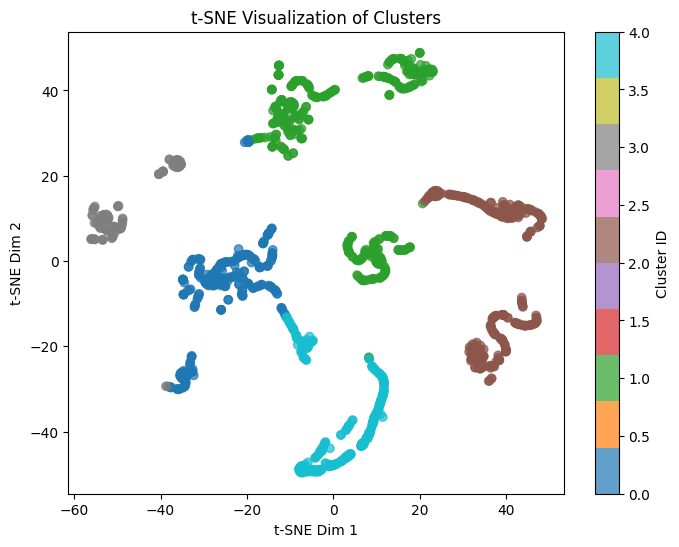

In [ ]:
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

# Reduce embeddings (high-dim) → 2D with t-SNE
tsne = TSNE(n_components=2, random_state=0, perplexity=30, n_iter=1000)
embeddings_2d = tsne.fit_transform(embeddings)

# Plot
plt.figure(figsize=(8, 6))
scatter = plt.scatter(
    embeddings_2d[:, 0],
    embeddings_2d[:, 1],
    c=labels,
    cmap="tab10",
    alpha=0.7
)

plt.title("t-SNE Visualization of Clusters")
plt.xlabel("t-SNE Dim 1")
plt.ylabel("t-SNE Dim 2")
plt.colorbar(scatter, label="Cluster ID")
plt.show()